In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!unzip '/content/drive/My Drive/Dataset/hand-gesture.zip' -d '/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/07/06_index/frame_07_06_0027.png  
  inflating: /dataset/07/06_index/frame_07_06_0028.png  
  inflating: /dataset/07/06_index/frame_07_06_0029.png  
  inflating: /dataset/07/06_index/frame_07_06_0030.png  
  inflating: /dataset/07/06_index/frame_07_06_0031.png  
  inflating: /dataset/07/06_index/frame_07_06_0032.png  
  inflating: /dataset/07/06_index/frame_07_06_0033.png  
  inflating: /dataset/07/06_index/frame_07_06_0034.png  
  inflating: /dataset/07/06_index/frame_07_06_0035.png  
  inflating: /dataset/07/06_index/frame_07_06_0036.png  
  inflating: /dataset/07/06_index/frame_07_06_0037.png  
  inflating: /dataset/07/06_index/frame_07_06_0038.png  
  inflating: /dataset/07/06_index/frame_07_06_0039.png  
  inflating: /dataset/07/06_index/frame_07_06_0040.png  
  inflating: /dataset/07/06_index/frame_07_06_0041.png  
  inflating: /dataset/07/06_index/frame_07_06_0042.png  
  inflating: /dataset/07/06_index/fra

In [3]:
import sys
import os
import numpy as np
from PIL import Image
import string
import matplotlib.pyplot as plt

from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model

DATA_DIR = '/dataset'

In [4]:
def preprocessing():
  datagen = ImageDataGenerator(
      rescale=1./255,
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest',
      validation_split=0.2
  )

  train_generator = datagen.flow_from_directory(
      DATA_DIR,
      target_size=(224, 224),
      batch_size=64,
      class_mode='categorical',
      subset='training'
  )

  validation_generator = datagen.flow_from_directory(
      DATA_DIR,
      target_size=(224, 224),
      batch_size=64,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, validation_generator

In [5]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs is None:
      logs = {}
    if logs.get('val_accuracy') >= 0.98:
      print(f'Epoch {epoch}: Reached accuracy threshold')
      self.model.stop_training = True

In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

def create_model(model_name, num_classes):
  if model_name == "VGG19":
    base_model = VGG19(weights='imagenet', include_top=False)
  elif model_name == "InceptionV3":
    base_model = InceptionV3(weights='imagenet', include_top=False)
  elif model_name == "ResNet50":
    base_model = ResNet50(weights='imagenet', include_top=False)
  elif model_name == "EfficientNetB7":
    base_model = EfficientNetB7(weights='imagenet', include_top=False)

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.2)(x)
  predictions = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze layers up to the 7th layer
  for layer in base_model.layers:
    layer.trainable = False

  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [12]:
model_names = ["VGG19", "InceptionV3", "ResNet50", "EfficientNetB7"]

def train(epochs, batch_size, verbose, num_classes):
  train_generator, validation_generator = preprocessing()

  callback = mycallback()

  # Create list of model

  history_list = []
  for model_name in model_names:
    print(f'\n Training on {model_name}... \n')
    model = create_model(model_name, num_classes)
    history = model.fit(train_generator,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = verbose,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2), callback],
                        validation_data = validation_generator)
    history_list.append(history)

  return history_list

In [13]:
epochs = 10
batch_size = 32
verbose = 2

num_classes = 10

history_list = train(epochs, batch_size, verbose, num_classes)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.

 Training on VGG19... 

Epoch 1/10
250/250 - 119s - loss: 1.7820 - accuracy: 0.3894 - val_loss: 2.0436 - val_accuracy: 0.2862 - 119s/epoch - 478ms/step
Epoch 2/10
250/250 - 94s - loss: 0.7516 - accuracy: 0.7469 - val_loss: 1.9945 - val_accuracy: 0.3560 - 94s/epoch - 376ms/step
Epoch 3/10
250/250 - 94s - loss: 0.3956 - accuracy: 0.8736 - val_loss: 3.1043 - val_accuracy: 0.3315 - 94s/epoch - 375ms/step
Epoch 4/10
250/250 - 94s - loss: 0.2773 - accuracy: 0.9190 - val_loss: 2.2853 - val_accuracy: 0.5240 - 94s/epoch - 377ms/step
Epoch 5/10
250/250 - 95s - loss: 0.2238 - accuracy: 0.9334 - val_loss: 5.0144 - val_accuracy: 0.2733 - 95s/epoch - 380ms/step
Epoch 6/10
250/250 - 94s - loss: 0.1873 - accuracy: 0.9476 - val_loss: 2.7094 - val_accuracy: 0.4717 - 94s/epoch - 376ms/step
Epoch 7/10
250/250 - 94s - loss: 0.1667 - accuracy: 0.9508 - val_loss: 3.0227 - val_accuracy: 0.4778 - 94s/epoch - 377ms/step
Epoc

In [21]:
def process_callback_figure(val_accuracy, val_loss, size):
  if len(val_accuracy) != size:
    val_accuracy.append(0)
    val_loss.append(0)
  return val_accuracy, val_loss

In [61]:
def visualization(val_accuracy_list, val_loss_list, model_names):
    epochs = range(len(val_accuracy_list[0]))

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))

    for index in range(len(val_accuracy_list)):
        # Validation accuracy visualization
        axes[0].plot(epochs, val_accuracy_list[index], label=model_names[index])
        axes[0].set_title('Validation accuracy between models')
        axes[0].legend()

        # Validation loss visualization
        axes[1].plot(epochs, val_loss_list[index], label=model_names[index])
        axes[1].set_title('Validation loss between models')
        axes[1].legend()

    plt.tight_layout()
    plt.show()

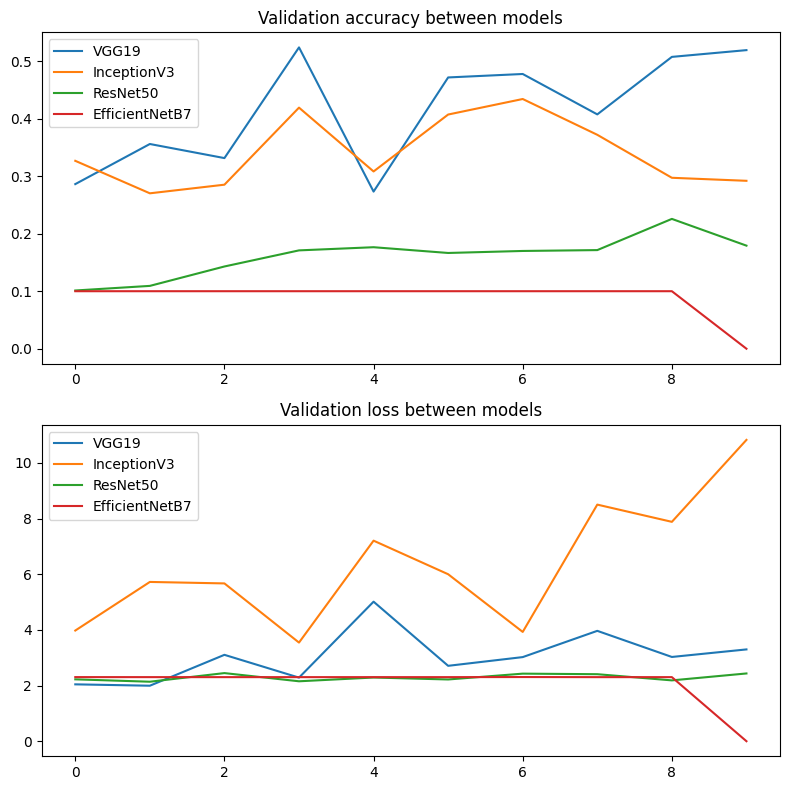

In [62]:
val_accuracy_list = []
val_loss_list = []

model_names = ["VGG19", "InceptionV3", "ResNet50", "EfficientNetB7"]

for history in history_list:
  val_accuracy = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  process_callback_figure(val_accuracy, val_loss, epochs)

  val_accuracy_list.append(val_accuracy)
  val_loss_list.append(val_loss)

visualization(val_accuracy_list, val_loss_list, model_names)